In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

summary_features = pd.read_csv('/content/participant_summary_new.csv')
#summary_features = pd.read_csv('/content/drive/My Drive/full_participant_summary.csv')

print(summary_features.shape)

(275, 1014)


In [ ]:
new_names = []
for i in range(1, 50):  # f1 to f49
    for stat in ['mean', 'std', 'min', 'max']:
        new_names.append(f'OpenFace_f{i}_{stat}')

# Apply renaming to your dataframe
column_indices_to_rename = range(802, 998)  # Inclusive of 802 to 997
summary_features.columns.values[list(column_indices_to_rename)] = new_names

In [ ]:
summary_features = summary_features.loc[:, (summary_features != 0).any(axis=0)]

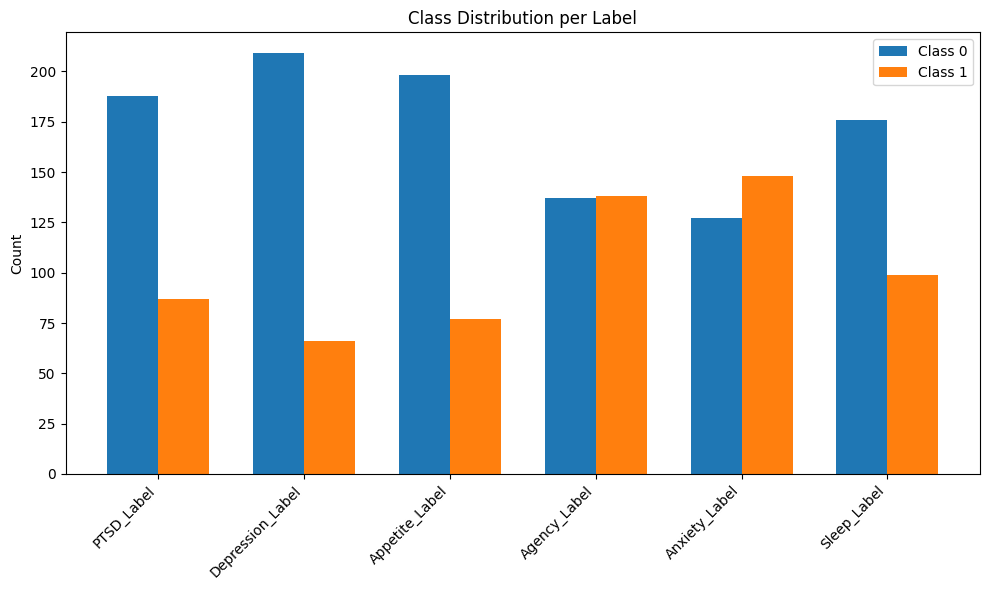

In [ ]:
import matplotlib.pyplot as plt

# Load your label CSV
df = pd.read_csv('/content/GroundTruth Table.csv')

# Define labels
labels = ['PTSD_Label',	'Depression_Label',	'Appetite_Label',	'Agency_Label',	'Anxiety_Label',	'Sleep_Label']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(labels))
zeros = [df[label].value_counts().get(0, 0) for label in labels]
ones = [df[label].value_counts().get(1, 0) for label in labels]

bar_width = 0.35
ax.bar([i - bar_width/2 for i in x], zeros, width=bar_width, label='Class 0')
ax.bar([i + bar_width/2 for i in x], ones, width=bar_width, label='Class 1')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Class Distribution per Label')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Separate features (summary_features) and the identified labels
X = summary_features
y = df[labels[0]] #i =0, 1, 2, 3, 4, 5 for diffrent targets

# Initialize StratifiedKFold with 5 splits
n_splits = 5  # Set to 5 for 5 iterations/folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
y.shape

(275,)

In [ ]:
X.shape

(275, 806)

In [ ]:
X = summary_features.copy()

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [ ]:
discrete_features

,0
participant_id,True
eGeMAPS_f1_mean,False
eGeMAPS_f1_std,False
eGeMAPS_f1_max,False
eGeMAPS_f2_mean,False
...,...
depression_word_count,True
anxiety_word_count,True
stress_word_count,True
ptsd_word_count,True


In [ ]:
X.shape

(275, 806)

In [ ]:
X.head()

,participant_id,eGeMAPS_f1_mean,eGeMAPS_f1_std,eGeMAPS_f1_max,eGeMAPS_f2_mean,eGeMAPS_f2_std,eGeMAPS_f2_max,eGeMAPS_f3_mean,eGeMAPS_f3_std,eGeMAPS_f3_max,...,lexical_diversity,first_person_pronoun_count,negation_count,sleep_word_count,appetite_word_count,depression_word_count,anxiety_word_count,stress_word_count,ptsd_word_count,harm_word_count
0,300,0.339651,0.412770,1.633468,0.309486,0.527131,2.008600,0.098401,0.224203,1.079181,...,0.336842,62,9,1,0,2,1,0,1,2
1,301,0.417114,0.383984,1.462398,0.508682,0.565141,1.963788,0.048905,0.167753,1.000000,...,0.238649,150,23,1,0,3,1,1,3,2
2,302,0.431654,0.399046,1.414973,0.008801,0.083450,1.041393,0.070662,0.204610,0.954242,...,0.330756,81,13,1,2,2,2,0,1,2
3,303,0.688838,0.391137,1.544068,1.028125,0.639955,2.037427,0.041777,0.147273,0.954242,...,0.211736,164,16,6,1,3,2,1,3,1
4,304,0.594773,0.377326,1.477121,0.658804,0.659056,1.977724,0.043229,0.154882,0.903090,...,0.269373,120,21,4,0,1,1,0,2,1


In [ ]:
y.shape

(275,)

In [ ]:
from sklearn.feature_selection import mutual_info_classif


In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)

    return mi_scores

# mi_scores = make_mi_scores(X, y, discrete_features)
# mi_scores  # show a few features with their MI scores

# Model for Temporal Features (CNN+BILSTM)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, BatchNormalization, GlobalMaxPooling1D, Dropout
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
MAX_CHUNKS = 87

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca(X_all):
  pca = PCA(n_components=40)  # or 50, depending on desired reduction
  X_embed_scaled = StandardScaler().fit_transform(X_all.iloc[:,-384:])

  X_reduced = pca.fit_transform(X_embed_scaled)

  # Explained variance ratio for each component
  explained_variance_ratio = pca.explained_variance_ratio_

  # Cumulative explained variance
  cumulative_variance = np.cumsum(explained_variance_ratio)

  # Replacing SBERT embeddings with PCs
  # Step 1: Drop the last 384 columns
  X_all = X_all.iloc[:, :-384]

  # Step 2: Convert X_reduced (NumPy array) to DataFrame
  X_reduced_df = pd.DataFrame(X_reduced, index=X_all.index)

  # Optional: rename columns
  X_reduced_df.columns = [f'embed_{i}' for i in range(X_reduced_df.shape[1])]

  # Step 3: Concatenate
  X_all = pd.concat([X_all, X_reduced_df], axis=1)
  return X_all

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Bidirectional, LSTM, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import re
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    elif epoch == 20:
        return lr * 0.1
    elif epoch == 40:
        return lr * 0.1
    else:
        return lr

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Wrap your model in a function
def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_model_ragged(input_dim):
    inp = Input(shape=(None, input_dim))  # variable-length support

    x = Conv1D(4, kernel_size=5, activation='relu')(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # x = SimpleRNN(4, return_sequences=True)(x)
    x = Bidirectional(LSTM(4, return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)

    x = Dense(4, activation='tanh')(x)
    x = Dropout(0.3)(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def remove_padding(X):
    sequences = []
    for x in X:
        # Find non-zero time steps (axis=1 because time is axis 0 in x)
        non_zero_mask = np.any(x != 0, axis=1)
        trimmed = x[non_zero_mask]
        sequences.append(trimmed)
    return sequences


# TEMPORAL FEATURES MODEL

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Function to compute metrics
def compute_metrics_dl(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn) if (tp + fn) else 0
    spec = tn / (tn + fp) if (tn + fp) else 0
    return round(acc, 4), round(sens, 4), round(spec, 4)

# Result holder: label -> [acc, sens, spec]
results_dl = {}
df = pd.read_csv('/content/GroundTruth Table.csv')
MAX_CHUNKS = 87
# Replace these with your actual label list and data (X_all_label, y_all_label)
labels = ['Appetite_Label', 'Anxiety_Label', 'Sleep_Label', 'Agency_Label', 'Depression_Label', 'PTSD_Label']
extracted_features = []
extra_features = [f"feature_{i}" for i in range(249, 633)]
extracted_features.extend(extra_features)

X_all_label = pd.read_csv('/content/All_features.csv', usecols = extracted_features)  # shape: (samples, MAX_CHUNKS, features) for this label
print(X_all_label.shape)
X_all_label = apply_pca(X_all_label)

for label in labels:
    # X = summary_features.copy()
    # y = df[label]

    # discrete_features = [False] * X.shape[1]
    # mi_scores = make_mi_scores(X, y, discrete_features)
    # filtered_scores = mi_scores[mi_scores > 0]
    # filtered_X = X[filtered_scores.index]

    # # Drop highly correlated features
    # corr_matrix = filtered_X.corr().abs()
    # to_drop = {
    #     col2 if filtered_scores[col1] >= filtered_scores[col2] else col1
    #     for i, col1 in enumerate(corr_matrix.columns)
    #     for j, col2 in enumerate(corr_matrix.columns)
    #     if i < j and corr_matrix.loc[col1, col2] > 0.8
    # }

    # final_X = filtered_X.drop(columns=to_drop)
    # final_scores = filtered_scores.drop(labels=to_drop)

    # # Select top 20% features
    # top_features = final_scores.sort_values(ascending=False).head(int(len(final_scores) * 0.2))
    # top_features_list = top_features.index.tolist()

    # extracted_features = []

    # for feature in top_features_list:
    #     match = re.match(r'^(MFCC|eGeMAPS|FAU)_f(\d+)_((?:mean)|(?:std)|(?:min)|(?:max))$', feature)
    #     if match:
    #         category, number, _ = match.groups()
    #         number = int(number)
    #         if category == "MFCC":
    #             mapped = f"feature_{number-1}"
    #         elif category == "eGeMAPS":
    #             mapped = f"feature_{number + 100-1}"
    #         # elif category == "FAU":
    #         #     mapped = f"feature_{number + 200-1}"
    #         extracted_features.append(mapped)
    # # extra_features = [f"feature_{i}" for i in range(249, 633)]
    # # extracted_features.extend(extra_features)


    print(f"\n=== Deep Learning on {label} ===")
    y_all_label = df[label] # binary labels for this label
    X_all_label = np.array(X_all_label)
    print(X_all_label.shape)
    X_all_label = X_all_label.reshape(275, 87, -1)
    print(X_all_label.shape)


    fold_metrics = []

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X_all_label, y_all_label):
        X_train, X_test = X_all_label[train_index], X_all_label[test_index]
        y_train, y_test = y_all_label[train_index], y_all_label[test_index]

        X_flat = X_train.reshape((X_train.shape[0], -1))
        ros = RandomOverSampler()
        X_resampled, y_resampled = ros.fit_resample(X_flat, y_train)
        X_train = X_resampled.reshape((-1, 87, X_train.shape[2]))
        y_train = to_categorical(y_resampled)

        X_train = X_train[:,:,:]
        X_test = X_test[:,:,:]

        X_train = remove_padding(X_train)
        X_test = remove_padding(X_test)

        X_train = tf.ragged.constant(X_train, dtype=tf.float32)
        X_test = tf.ragged.constant(X_test, dtype=tf.float32)
        y_test = to_categorical(y_test)

        X_train = X_train.to_tensor()
        X_test = X_test.to_tensor()

        model = build_model_ragged(input_dim=X_train.shape[2])
        model.fit(X_train, y_train, batch_size=16, epochs=15, validation_data=(X_test, y_test), callbacks=[lr_scheduler], verbose=1, shuffle=True)

        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_test = np.argmax(y_test, axis=1)
        acc, sens, spec = compute_metrics_dl(y_test, y_pred)
        fold_metrics.append((acc, sens, spec))

    avg_metrics = np.mean(fold_metrics, axis=0)
    results_dl[label] = list(map(lambda x: round(x, 4), avg_metrics))


(23925, 384)

=== Deep Learning on Appetite_Label ===
(23925, 40)
(275, 87, 40)

Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.5516 - loss: 0.7220 - val_accuracy: 0.7455 - val_loss: 0.5496 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6338 - loss: 0.6501 - val_accuracy: 0.8000 - val_loss: 0.5322 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7273 - loss: 0.6046 - val_accuracy: 0.7636 - val_loss: 0.4840 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7415 - loss: 0.5832 - val_accuracy: 0.8182 - val_loss: 0.4839 - learning_rate: 0.0100

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import re

# Function to compute metrics
def compute_metrics_dl(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn) if (tp + fn) else 0
    spec = tn / (tn + fp) if (tn + fp) else 0
    return acc, sens, spec  # keep raw (not rounded yet)

# Store mean ± std dev metrics
results_dl = {}

df = pd.read_csv('/content/GroundTruth Table.csv')
MAX_CHUNKS = 87
labels = ['Appetite_Label', 'Anxiety_Label', 'Sleep_Label', 'Agency_Label', 'Depression_Label', 'PTSD_Label']

for label in labels:
    print(f"\n=== Deep Learning on {label} ===")
    X = summary_features.copy()
    y = df[label]

    discrete_features = [False] * X.shape[1]
    mi_scores = make_mi_scores(X, y, discrete_features)
    filtered_scores = mi_scores[mi_scores > 0]
    filtered_X = X[filtered_scores.index]

    # Drop highly correlated features
    corr_matrix = filtered_X.corr().abs()
    to_drop = {
        col2 if filtered_scores[col1] >= filtered_scores[col2] else col1
        for i, col1 in enumerate(corr_matrix.columns)
        for j, col2 in enumerate(corr_matrix.columns)
        if i < j and corr_matrix.loc[col1, col2] > 0.8
    }

    final_X = filtered_X.drop(columns=to_drop)
    final_scores = filtered_scores.drop(labels=to_drop)

    # Select top 20% features
    top_features = final_scores.sort_values(ascending=False).head(int(len(final_scores) * 0.2))
    top_features_list = top_features.index.tolist()

    # Map feature names to All_features.csv naming
    extracted_features = []
    for feature in top_features_list:
        match = re.match(r'^(MFCC|eGeMAPS|FAU)_f(\d+)_((?:mean)|(?:std)|(?:min)|(?:max))$', feature)
        if match:
            category, number, _ = match.groups()
            number = int(number)
            if category == "MFCC":
                mapped = f"feature_{number-1}"
            elif category == "eGeMAPS":
                mapped = f"feature_{number + 99}"
            elif category == "FAU":
                mapped = f"feature_{number + 199}"
            extracted_features.append(mapped)

    # Load extracted features
    X_all_label = pd.read_csv('/content/All_features.csv', usecols=extracted_features)
    y_all_label = df[label]

    X_all_label = np.array(X_all_label).reshape(275, MAX_CHUNKS, -1)
    X_all_label = X_all_label[:, :-1, :]
    y_all_label = np.array(y_all_label)

    # Store all metrics across 10 runs
    all_runs_metrics = []

    for run in range(10):
        fold_metrics = []
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42 + run)

        for train_index, test_index in kf.split(X_all_label, y_all_label):
            X_train, X_test = X_all_label[train_index], X_all_label[test_index]
            y_train, y_test = y_all_label[train_index], y_all_label[test_index]

            model = build_model(input_shape=(X_all_label.shape[1], X_all_label.shape[2]))
            model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=0)

            y_pred_prob = model.predict(X_test)
            y_pred = (y_pred_prob > 0.5).astype(int)

            acc, sens, spec = compute_metrics_dl(y_test, y_pred)
            fold_metrics.append((acc, sens, spec))

        all_runs_metrics.append(np.mean(fold_metrics, axis=0))

    all_runs_metrics = np.array(all_runs_metrics)
    means = np.mean(all_runs_metrics, axis=0)
    stds = np.std(all_runs_metrics, axis=0)

    results_dl[label] = {
        "accuracy": f"{means[0]:.4f} ± {stds[0]:.4f}",
        "sensitivity": f"{means[1]:.4f} ± {stds[1]:.4f}",
        "specificity": f"{means[2]:.4f} ± {stds[2]:.4f}"
    }

# Convert to DataFrame and save
summary_df = pd.DataFrame(results_dl).T
summary_df.index.name = "Label"

print("\n===== Final Deep Learning Metrics (10 runs, mean ± std) =====")
print(summary_df)

summary_df.to_csv("dl_summary_metrics.csv")



=== Deep Learning on Appetite_Label ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 490ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 440ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step
2/2 ━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd

# Create a DataFrame from the results dictionary
dl_df = pd.DataFrame.from_dict(
    results_dl,
    orient='index',
    columns=['Accuracy', 'Sensitivity', 'Specificity']
)

# Add model name as a column
dl_df.insert(0, 'Model', 'Deep CNN-BiLSTM')

# Reorder index (labels become columns)
dl_df = dl_df.transpose()
dl_df.columns = [f'{label}' for label in dl_df.columns]

# Optional: flatten the multi-index style
dl_df.reset_index(inplace=True)
dl_df.rename(columns={'index': 'Metric'}, inplace=True)

# Save to CSV
dl_df.to_csv("deep_model_results.csv", index=False)

# Display it
print("\nSaved Deep Learning metrics to 'deep_model_results.csv':\n")
print(dl_df)



Saved Deep Learning metrics to 'deep_model_results.csv':

        Metric   Appetite_Label    Anxiety_Label      Sleep_Label  \
0        Model  Deep CNN-BiLSTM  Deep CNN-BiLSTM  Deep CNN-BiLSTM   
1     Accuracy           0.6582           0.6582           0.6182   
2  Sensitivity             0.48            0.669           0.5632   
3  Specificity           0.7267           0.6455           0.6467   

      Agency_Label Depression_Label       PTSD_Label  
0  Deep CNN-BiLSTM  Deep CNN-BiLSTM  Deep CNN-BiLSTM  
1           0.6146           0.6473             0.72  
2           0.6598           0.3791           0.4013  
3           0.5693           0.7317           0.8669  
